<a href="https://colab.research.google.com/github/taavip/Forest-classification/blob/main/work_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [252]:
pip install OWSLib dask_geopandas rasterio

# Download EHAK

In [253]:
import requests
import geopandas as gpd

def load_wfs_layer(base_url, layer_name, bbox=None, filter_query=None, properties=None):
    params = {
        "service": "WFS",
        "version": "2.0.0",
        "request": "GetFeature",
        "typeName": layer_name,
        "outputFormat": "application/json",
        "srsName": "EPSG:3301"
    }
    if bbox:
        params["bbox"] = f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:3301"
    if filter_query:
        params["CQL_FILTER"] = filter_query

    # Print the full URL for debugging
    full_url = requests.Request('GET', base_url, params=params).prepare().url
    print(f"Request URL: {full_url}")

    response = requests.get(base_url, params=params)
    response.raise_for_status()
    gdf = gpd.read_file(response.content)

    if properties:
        gdf = gdf[properties + ['geometry']]  # Keep only necessary columns
    return gdf

# URL and layer information
kov_layer = "ehak:omavalitsuste_piirid"
kov_url = "https://gsavalik.envir.ee/geoserver/ehak/ows"

# Load entire KOV layer without any filtering
try:
    gdf_kov = load_wfs_layer(kov_url, kov_layer)
    print(f"Loaded {len(gdf_kov)} features from the EHAK layer")
except Exception as e:
    print(f"Error: {e}")


Request URL: https://gsavalik.envir.ee/geoserver/ehak/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=ehak%3Aomavalitsuste_piirid&outputFormat=application%2Fjson&srsName=EPSG%3A3301
Loaded 79 features from the EHAK layer


# Selecting Local government

In [254]:
kov = "Muhu"  # Define the value to filter

# Filter rows where 'omavalitus' contains the value in KOV (case-insensitive)
kov_filtered_gdf = gdf_kov[gdf_kov['omavalitsus'].str.contains(kov, case=False, na=False)]

print(f"Filtered {len(kov_filtered_gdf)} rows matching '{kov}'.")
kov_filtered_gdf


Filtered 1 rows matching 'Muhu'.


,id,fid,ehak_kood,omavalitsus,tyyp,maakond_kood,maakond,vers_algus,vers_lopp,seaduslik_alus,geometry
3,omavalitsuste_piirid.3,3,0478,Muhu vald,vald,0074,Saare maakond,2007-01-31 13:24:41+00:00,None,Regionaalministri määrus nr 9,"MULTIPOLYGON (((454872.656 6487276.233, 454868..."


In [255]:
# Get the BBOX of the filtered GeoDataFrame
bbox = kov_filtered_gdf.total_bounds.tolist()  # Returns [minx, miny, maxx, maxy]

print(f"BBOX for {kov}: {bbox}")


BBOX for Muhu: [445750.25909424, 6482845.2020874, 467746.47808838, 6505348.67108154]


# Download Metsaregister

In [256]:
metsaregister_url = "https://gsavalik.envir.ee/geoserver/metsaregister/ows"
metsaregister_eraldis_layer = "metsaregister:eraldis"

metsaregister_bbox_gdf = load_wfs_layer(
    base_url=metsaregister_url,
    layer_name=metsaregister_eraldis_layer,
    bbox = bbox
)
# Create spatial index
metsaregister_bbox_gdf.sindex

Request URL: https://gsavalik.envir.ee/geoserver/metsaregister/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=metsaregister%3Aeraldis&outputFormat=application%2Fjson&srsName=EPSG%3A3301&bbox=445750.25909424%2C6482845.2020874%2C467746.47808838%2C6505348.67108154%2CEPSG%3A3301


In [257]:


num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 2


In [258]:
import time
import dask_geopandas as dgpd
import os

start_time = time.time()

# Get CPU cores
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

# Convert GeoDataFrames to Dask-GeoDataFrames
kov_filtered_dd = dgpd.from_geopandas(kov_filtered_gdf, npartitions=num_cores)  # Adjust npartitions as needed
metsaregister_dd = dgpd.from_geopandas(metsaregister_bbox_gdf, npartitions=num_cores)  # Adjust npartitions as needed

# Perform spatial join using Dask-GeoPandas, keeping only 'index_right'
metsaregister_kov_gdf = dgpd.sjoin(metsaregister_dd, kov_filtered_dd, how="inner", predicate="within").compute()

# Filter the original metsaregister_bbox_gdf based on the index
metsaregister_kov_gdf = metsaregister_bbox_gdf[metsaregister_bbox_gdf.index.isin(metsaregister_kov_gdf.index)]

# Reset index before saving
metsaregister_kov_gdf = metsaregister_kov_gdf.reset_index(drop=True)

# Save the filtered GeoDataFrame to a file (e.g., GeoPackage)
output_filename = "metsaregister_in_kov.gpkg"
metsaregister_kov_gdf.to_file(output_filename, driver="GPKG")

print(f"Saved spatial join result to {output_filename}")

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Saved spatial join result to metsaregister_in_kov.gpkg
Execution time: 0.7015094757080078 seconds


## Visualize Metsaregister

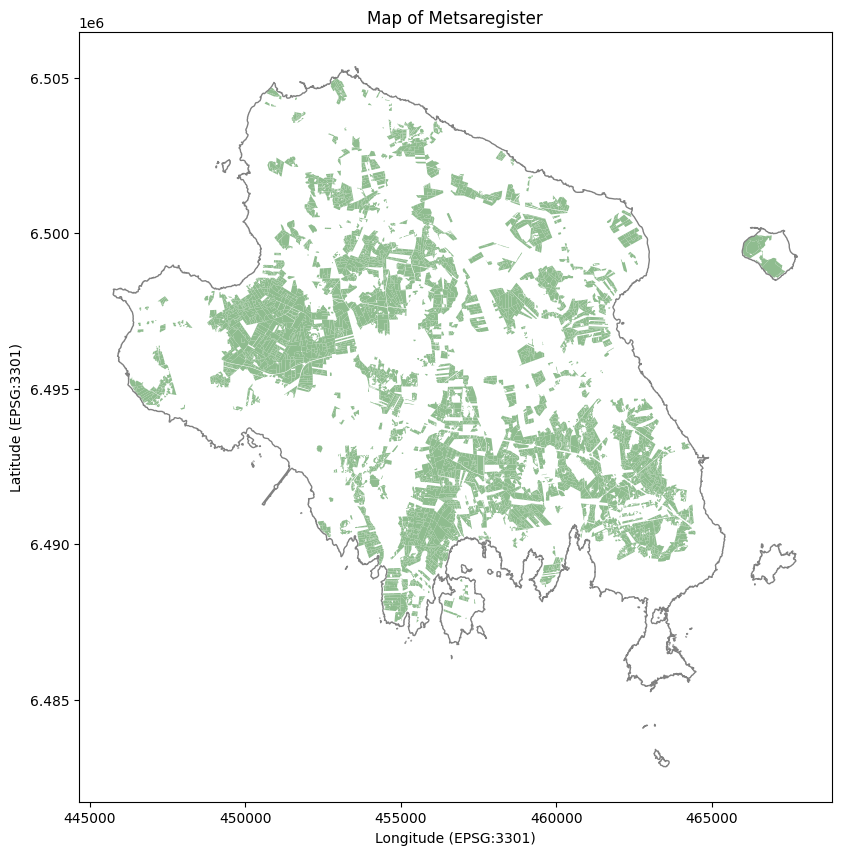

In [259]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_vektor_map(geodataframe, kov_filtered_gdf, title="Map of Metsaregister"): # added kov_filtered_gdf as argument
    """
    Plots a map of forest areas using a GeoDataFrame.

    Args:
        geodataframe (geopandas.GeoDataFrame): The GeoDataFrame containing forest polygons.
        kov_filtered_gdf (geopandas.GeoDataFrame): GeoDataFrame with KOV boundaries.
        title (str, optional): The title of the map. Defaults to "Map of Metsaregister (EPSG:3301)".
    """

    # Ensure both GeoDataFrames are in EPSG:3301
    geodataframe = geodataframe.to_crs(epsg=3301)
    kov_filtered_gdf = kov_filtered_gdf.to_crs(epsg=3301)

    # Create the plot with forest green color and no edges
    fig, ax = plt.subplots(figsize=(10, 10)) #create fig and ax
    geodataframe.plot(ax=ax, edgecolor='none', color='#8FBC8F')

    # Plot kov_filtered_gdf with gray edge and no fill
    kov_filtered_gdf.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=1)

    plt.title(title)
    plt.xlabel("Longitude (EPSG:3301)")
    plt.ylabel("Latitude (EPSG:3301)")

    plt.show()

# Now when calling the function, you need to pass both GeoDataFrames:
plot_vektor_map(metsaregister_kov_gdf, kov_filtered_gdf)

# Download eraldis element from Metsaregister

In [260]:
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor

# Function to process each chunk
def process_chunk(chunk, metsaregister_url, metsaregister_eraldis_element_layer):
    """
    Processes a chunk of IDs to filter data from the WFS layer.
    """
    filter_query = "eraldis_id IN (" + ",".join(map(str, chunk)) + ")"
    metsaregister_gdf_eraldis_element = load_wfs_layer(
        metsaregister_url,
        metsaregister_eraldis_element_layer,
        filter_query=filter_query
    )
    print(f"Processed chunk: {len(metsaregister_gdf_eraldis_element)} features")
    return metsaregister_gdf_eraldis_element

# Function to split data into chunks
def split_into_chunks(data, chunk_size):
    """
    Splits the data into smaller chunks of the given size.
    """
    return [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

# Parameters
eraldis_unique_ids = metsaregister_kov_gdf['id'].unique()
chunk_size = 700
max_workers = 64  # Adjust this based on available system resources
eraldis_unique_ids = metsaregister_kov_gdf['id'].unique()
metsaregister_eraldis_element_layer = "metsaregister:eraldis_element"

# Start timing the code
start_time = time.time()

# Split the unique IDs into smaller chunks
chunks = split_into_chunks(eraldis_unique_ids, chunk_size)

# Use ThreadPoolExecutor to process chunks in parallel
metsaregister_gdf_eraldis_element = []
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = executor.map(
        lambda chunk: process_chunk(chunk, metsaregister_url, metsaregister_eraldis_element_layer),
        chunks
    )

    # Collect results as they complete
    metsaregister_gdf_eraldis_element.extend(results)

# Concatenate all the chunks into a single GeoDataFrame
metsaregister_gdf_eraldis_element_all = pd.concat(metsaregister_gdf_eraldis_element, ignore_index=True)

# End timing the code
end_time = time.time()
elapsed_time = end_time - start_time

# Print results
print(f"Total features: {len(metsaregister_gdf_eraldis_element_all)}")
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Request URL: https://gsavalik.envir.ee/geoserver/metsaregister/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=metsaregister%3Aeraldis_element&outputFormat=application%2Fjson&srsName=EPSG%3A3301&CQL_FILTER=eraldis_id+IN+%289977675%2C6232141%2C6951935%2C7839123%2C7839127%2C8145677%2C5117753%2C551208%2C551206%2C7982971%2C5151121%2C1724514%2C1724512%2C9748043%2C815614%2C10208025%2C486537%2C11047615%2C5216395%2C216180%2C1733066%2C1733078%2C2983227%2C3439131%2C9067533%2C6675069%2C8345541%2C2312305%2C2322739%2C5150183%2C5216447%2C2391123%2C638734%2C5150373%2C553618%2C553624%2C1555261%2C1555263%2C570140%2C3439135%2C570528%2C570524%2C570526%2C1534444%2C1534500%2C574826%2C5151233%2C1534450%2C8515305%2C588200%2C1540996%2C1540970%2C1541000%2C1540998%2C1534514%2C1534516%2C1551464%2C9818035%2C10819431%2C1541010%2C1541006%2C1541002%2C1540982%2C901772%2C11057685%2C11057693%2C11057707%2C11057705%2C11057687%2C11057683%2C11057717%2C11057713%2C11057699%2C11057701%2C11057715%2C1737870%2C869574%2

## Aggregate eraldis height

In [261]:
# Start timing the code
start_time = time.time()

# Merge the two GeoDataFrames
merged_gdf = pd.merge(metsaregister_gdf_eraldis_element_all, metsaregister_kov_gdf, left_on='eraldis_id', right_on='id', how='right')

# Group by 'id_y' (which corresponds to metsaregister_kov_gdf's 'id') and calculate max and median of 'korgus'
aggregated_gdf = merged_gdf.groupby('id_y')['korgus'].agg(['max', 'median']).reset_index()

# Rename columns for clarity
aggregated_gdf.columns = ['id', 'max_korgus', 'median_korgus']

# Merge the aggregated data back into metsaregister_gdf
metsaregister_gdf = pd.merge(metsaregister_kov_gdf, aggregated_gdf, on='id', how='left')

# End timing the code
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.07314825057983398 seconds


## Filter forest layer

In [302]:
#find metsaregister_gdf all rows where max_korgus is less than 5 or area is less than 0,25 ha (first calculate the area of column geometry into the column 'pindala') and then delete them from metsaregister_gdf

# Rows before
rows_before =  len(metsaregister_gdf)

# Calculate area
metsaregister_gdf['pindala'] = metsaregister_gdf['geometry'].area / 10000  # Area in hectares

# Filter rows
metsaregister_gdf = metsaregister_gdf[~((metsaregister_gdf['max_korgus'] < 5) | (metsaregister_gdf['pindala'] < 0.25))]

# Count rows filtered
rows_filtered = rows_before - len(metsaregister_gdf)
print(f"{rows_filtered} rows filtered out of {rows_before}")



0 rows filtered out of 4763


# Remove spike vertices

In [300]:
from shapely.geometry import Polygon, MultiPolygon


# Convert to Polygon if necessary
def to_polygon(geom):
    if geom.geom_type == 'Polygon':
        return geom
    elif geom.geom_type == 'MultiPolygon':
        # For MultiPolygons, return the largest polygon by area
        return max(geom.geoms, key=lambda x: x.area)
    else:
        return Polygon(geom.exterior)

# Use .loc for explicit assignment
metsaregister_gdf.loc[:, 'geometry'] = metsaregister_gdf['geometry'].apply(to_polygon)

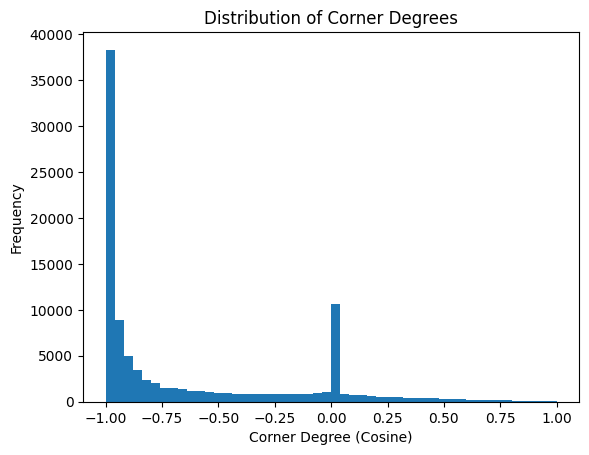

In [267]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import numpy as np


def calculate_corner_degrees(gdf):
    """Calculates corner degrees for all polygons in a GeoDataFrame."""
    all_corner_degrees = []
    for _, row in gdf.iterrows():
        polygon = row.geometry
        exterior = polygon.exterior
        coordinates = list(exterior.coords)
        num_coords = len(coordinates)
        for i in range(num_coords):
            prev = (i - 1) % num_coords
            next_p = (i + 1) % num_coords
            prev_vec = (coordinates[prev][0] - coordinates[i][0], coordinates[prev][1] - coordinates[i][1])
            next_vec = (coordinates[next_p][0] - coordinates[i][0], coordinates[next_p][1] - coordinates[i][1])
            dot_prod = prev_vec[0] * next_vec[0] + prev_vec[1] * next_vec[1]
            magn_prod = (prev_vec[0]**2 + prev_vec[1]**2)**0.5 * (next_vec[0]**2 + next_vec[1]**2)**0.5
            if magn_prod != 0:
                corner_degree = dot_prod / magn_prod  # Cosine of the angle
            else:
                corner_degree = 0  # Handle cases where magn_prod is 0
            all_corner_degrees.append(corner_degree)
    return all_corner_degrees


# Calculate and plot corner degree distribution
corner_degrees = calculate_corner_degrees(metsaregister_gdf)

plt.hist(corner_degrees, bins=50)  # Adjust bins as needed
plt.title("Distribution of Corner Degrees")
plt.xlabel("Corner Degree (Cosine)")
plt.ylabel("Frequency")
plt.show()

In [264]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import numpy as np

def remove_vertices_in_row(row, threshold=0.999):
    """
    Removes vertices with corner degree (cosine) close to 0 or abs bigger than threshold,
    but preserves the first and last vertices. If the result has less than 4 coordinates,
    it keeps the original geometry.
    """
    polygon = row.geometry
    exterior = polygon.exterior
    coordinates = list(exterior.coords)
    num_coords = len(coordinates)

    # Handle special cases where modification isn't possible
    if num_coords <= 4:  # Polygon already simple or invalid
        return row, 0, 0  # Return 0 for changes and deleted vertices

    new_coordinates = [coordinates[0]]
    deleted_vertices = 0

    for i in range(1, num_coords - 1):
        prev = (i - 1) % num_coords
        next_p = (i + 1) % num_coords

        prev_vec = (coordinates[prev][0] - coordinates[i][0],
                    coordinates[prev][1] - coordinates[i][1])
        next_vec = (coordinates[next_p][0] - coordinates[i][0],
                    coordinates[next_p][1] - coordinates[i][1])

        dot_prod = prev_vec[0] * next_vec[0] + prev_vec[1] * next_vec[1]
        magn_prod = (prev_vec[0]**2 + prev_vec[1]**2)**0.5 * (next_vec[0]**2 + next_vec[1]**2)**0.5

        corner_degree = dot_prod / magn_prod if magn_prod != 0 else 0

        if not (np.isclose(corner_degree, 0) or abs(corner_degree) > threshold):
            new_coordinates.append(coordinates[i])
        else:
            deleted_vertices += 1

    new_coordinates.append(coordinates[-1])

    geometry_changed = 0
    if len(new_coordinates) >= 4 and len(new_coordinates) != num_coords:
        new_polygon = Polygon(new_coordinates)
        row.geometry = new_polygon
        geometry_changed = 1

    return row, geometry_changed, deleted_vertices


def remove_vertices_parallel(gdf, threshold=0.999, num_processes=4):
    """
    Removes vertices in parallel based on corner degree (cosine).
    """
    gdf_copy = gdf.copy()

    if 'geometry' not in gdf_copy.columns or not all(isinstance(geom, Polygon) for geom in gdf_copy.geometry):
        raise ValueError("GeoDataFrame must have a 'geometry' column of Polygon type.")

    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(remove_vertices_in_row,
                                   [row for _, row in gdf_copy.iterrows()],
                                   [threshold] * len(gdf_copy)))

    # Separate results into rows, geometry_changed, and deleted_vertices
    rows, geometry_changed_flags, deleted_vertices_counts = zip(*results)

    gdf_modified = gpd.GeoDataFrame(rows, geometry='geometry', crs=gdf_copy.crs)

    total_geometries_changed = sum(geometry_changed_flags)
    total_vertices_deleted = sum(deleted_vertices_counts)

    print(f"Total geometries changed: {total_geometries_changed}")
    print(f"Total vertices deleted: {total_vertices_deleted}")

    return gdf_modified

In [265]:
metsaregister_gdf_modified = remove_vertices_parallel(metsaregister_gdf, threshold=0.9999, num_processes=8)

Total geometries changed: 2732
Total vertices deleted: 7153


## Validate geometries

In [266]:
import geopandas as gpd
from shapely.geometry import Polygon
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

def check_vertices_in_row(row):
    """Checks if the first and last vertices of a polygon are the same."""
    polygon = row.geometry
    if isinstance(polygon, Polygon):  # Check if it's a Polygon
        coordinates = list(polygon.exterior.coords)
        if coordinates[0] == coordinates[-1]:
            return True  # Vertices are the same
        else:
            return False  # Vertices are different
    else:
        return None  # Not a Polygon (e.g., Point, LineString)


def check_vertices_parallel(gdf, num_processes=4):
    """Checks vertices in parallel and prints statistics."""
    gdf_copy = gdf.copy()

    if 'geometry' not in gdf_copy.columns:
        raise ValueError("GeoDataFrame must have a 'geometry' column.")

    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(check_vertices_in_row, [row for _, row in gdf_copy.iterrows()]))

    # Calculate and print statistics
    total_polygons = len(results)
    closed_polygons = results.count(True)
    open_polygons = results.count(False)
    other_geometries = results.count(None)

    print(f"Total geometries: {total_polygons}")
    print(f"Closed polygons (first and last vertices are the same): {closed_polygons}")
    print(f"Open polygons (first and last vertices are different): {open_polygons}")
    print(f"Other geometries (not polygons): {other_geometries}")

    # Optionally, you can create a new column in the GeoDataFrame:
    gdf_copy['is_closed'] = results
    return gdf_copy

# Example usage:
# Assuming 'metsaregister_gdf' is your GeoDataFrame
metsaregister_gdf_with_stats = check_vertices_parallel(metsaregister_gdf_modified, num_processes=8)

Total geometries: 4765
Closed polygons (first and last vertices are the same): 4765
Open polygons (first and last vertices are different): 0
Other geometries (not polygons): 0


## Self_intersection

In [270]:
from shapely.geometry import Polygon
from shapely.validation import explain_validity
from shapely.ops import unary_union

def has_self_intersection(polygon):
    """Checks if a polygon has self-intersections."""
    if not isinstance(polygon, Polygon):
        return False  # Non-polygons don't have self-intersections

    validity = explain_validity(polygon)
    return "Self-intersection" in validity

def fix_self_intersections(polygon):
    """Fixes self-intersections in a polygon."""
    if not polygon.is_valid:
        # Try to fix the polygon using make_valid (Shapely v2)
        fixed_polygon = polygon.buffer(0)  # Buffering with 0 distance can fix small issues
        if not fixed_polygon.is_valid:
            fixed_polygon = unary_union(polygon)  # Alternative fix
        return fixed_polygon
    return polygon

# Apply the function to the 'geometry' column
metsaregister_gdf_modified['has_self_intersection'] = metsaregister_gdf_modified['geometry'].apply(has_self_intersection)

# Get the rows with self-intersections
self_intersecting_polygons = metsaregister_gdf_modified[metsaregister_gdf_modified['has_self_intersection']]

if not self_intersecting_polygons.empty:
    # Print the rows with self-intersecting polygons
    print("Rows with self-intersecting polygons:")
    print(self_intersecting_polygons)

    # Correct the self-intersections
    metsaregister_gdf_modified.loc[metsaregister_gdf_modified['has_self_intersection'], 'geometry'] = \
        metsaregister_gdf_modified.loc[metsaregister_gdf_modified['has_self_intersection'], 'geometry'].apply(fix_self_intersections)
else:
    metsaregister_gdf_modified.drop(columns=['has_self_intersection'], inplace=True)

# Count the number of self-intersections
num_self_intersections = len(self_intersecting_polygons)
print(f"Number of self-intersecting polygons: {num_self_intersections}")


Number of self-intersecting polygons: 0


## Visualize result

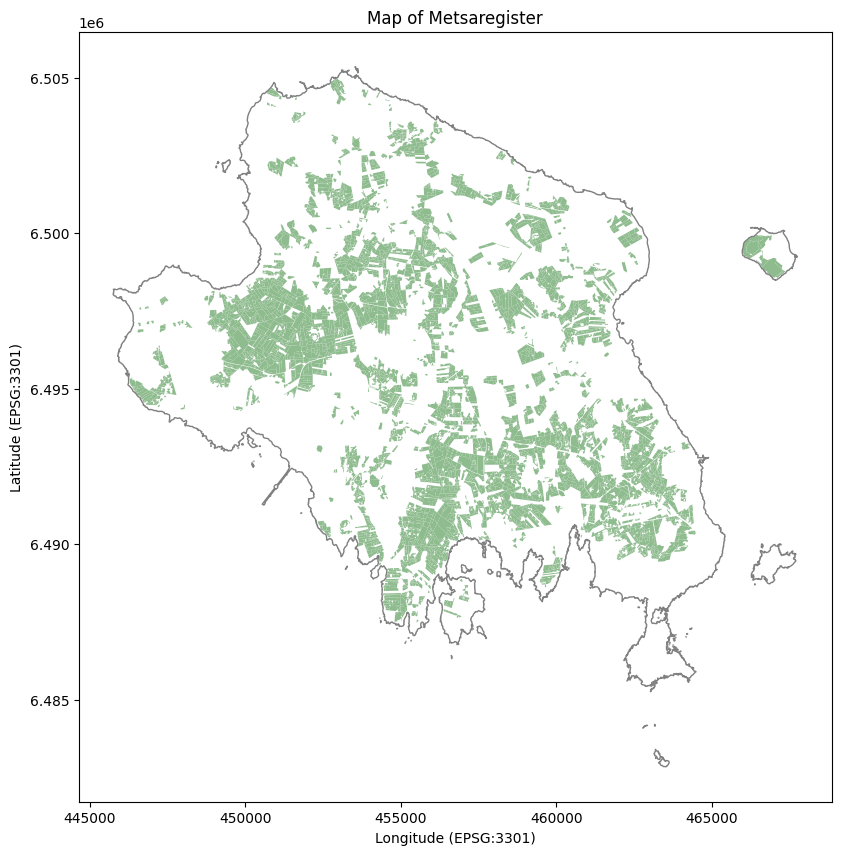

In [269]:
plot_vektor_map(metsaregister_gdf_modified, kov_filtered_gdf)


# Rasterization

In [271]:
import requests

# Define the URL of the raw file on GitHub
url = "https://raw.githubusercontent.com/taavip/Metsa-klassifitseerimine/main/referentsvorgustik.tif"

# Define the local file path to save the downloaded file
file_path = "referentsvorgustik.tif"

# Send a GET request to download the file
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Open the local file in binary write mode and save the downloaded content
    with open(file_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):  # Download in chunks
            file.write(chunk)
    print(f"File downloaded successfully to {file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully to referentsvorgustik.tif


## Create forest mask

In [272]:
import rasterio
from rasterio.features import rasterize # import rasterize function
from rasterio.mask import mask # import mask function
from shapely.geometry import box # import box function

def create_raster_mask(vector_data, base_raster_path, output_raster_path, value_column=None, crop_bbox=None):
    """
    Creates a raster mask from vector data using a specified column for values or a binary mask.
    Optionally crops the raster to a specified bounding box.

    Args:
        vector_data (GeoDataFrame): The input vector data.
        base_raster_path (str): Path to the base raster used as a template.
        output_raster_path (str): Path to save the raster mask.
        value_column (str, optional): Column in the GeoDataFrame to use for raster values.
                                      If None, creates a binary mask.
        crop_bbox (tuple, optional): Bounding box (minx, miny, maxx, maxy) for cropping.
                                     If None, no cropping is applied.
    """
    # Load the base raster for template metadata
    with rasterio.open(base_raster_path) as src:
        meta = src.meta.copy()
        transform = src.transform

    # Prepare shapes for rasterization
    if value_column:
        if value_column not in vector_data.columns:
            raise ValueError(f"Column '{value_column}' not found in vector data.")
        shapes = ((geom, value) for geom, value in zip(vector_data.geometry, vector_data[value_column]))
    else:
        shapes = ((geom, 1) for geom in vector_data.geometry)  # Binary mask with value 1

    # Rasterize the vector layer
    rasterized_data = rasterize(
        shapes=shapes,
        out_shape=(meta['height'], meta['width']),
        transform=transform,
        fill=0,  # Default value for no data areas
        dtype=meta['dtype']
    )

    # Update metadata
    meta.update({"driver": "GTiff", "dtype": rasterized_data.dtype})

    # Save the uncropped raster temporarily
    with rasterio.open(output_raster_path, 'w', **meta) as dst:
        dst.write(rasterized_data, 1)

    # If crop_bbox is provided, crop the raster
    if crop_bbox:
        crop_box = box(*crop_bbox)
        with rasterio.open(output_raster_path) as src:
            cropped_data, cropped_transform = mask(
                dataset=src,
                shapes=[crop_box],
                crop=True
            )
            meta.update({
                "height": cropped_data.shape[1],
                "width": cropped_data.shape[2],
                "transform": cropped_transform
            })

        # Save the cropped raster
        with rasterio.open(output_raster_path, 'w', **meta) as dst:
            dst.write(cropped_data[0], 1)  # Select the first band




In [273]:
# Example usage:
# 1. Create a binary mask with optional cropping
create_raster_mask(metsaregister_gdf_modified, '/content/referentsvorgustik.tif', 'metsaregister_binary.tif', crop_bbox=bbox)

# 2. Create a value-based mask using 'max_korgus' and crop it
create_raster_mask(metsaregister_gdf_modified, '/content/referentsvorgustik.tif', 'metsaregister_korgus.tif', value_column='max_korgus', crop_bbox=bbox)

## Removing individual pixels



In [275]:
import numpy as np
from skimage import measure
from skimage.morphology import remove_small_objects
from skimage.io import imread, imsave
import rasterio
import os

def clean_raster(raster_path, output_raster_path, min_cluster_size=5):
    """
    Puhastab rasterpildi üksikutest pikslitest, sulandades väiksemad klastrid (< min_cluster_size)
    ümbritsevatesse klastritesse. Säilitab sisendi rasteri profiili.

    Parameetrid:
    raster_path (str): Sisendi rasterpildi failitee.
    output_raster_path (str): Puhastatud rasterpildi failitee.
    min_cluster_size (int): Klasterite minimaalne suurus, alla mille need eemaldatakse.

    Tagastab:
    None
    """
    # Lae sisse binaarpilt ja profiil
    with rasterio.open(raster_path) as src:
        img = src.read(1)
        profile = src.profile

    # Convert img to boolean before applying remove_small_objects
    cleaned_img = remove_small_objects(img.astype(bool), min_size=min_cluster_size, connectivity=1)

    # Uuenda profiili andmetüüpi
    profile.update(dtype=rasterio.uint8)

    # Salvesta puhastatud pilt koos profiiliga
    with rasterio.open(output_raster_path, 'w', **profile) as dst:
        dst.write(cleaned_img.astype(rasterio.uint8), 1)

    print(f"Pilt on puhastatud ja salvestatud: {output_raster_path}")

In [276]:
# Andmete puhastamine üksikutest pikslitest
clean_raster('/content/metsaregister_binary.tif', 'cleaned_metsaregister_binary.tif', min_cluster_size=5)

Pilt on puhastatud ja salvestatud: cleaned_metsaregister_binary.tif


## Mask forest height

In [2]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

def apply_mask(raster_data, mask_data):
    """
    Apply a mask to the raster data.

    Parameters:
    - raster_data (ndarray): The target raster data to which the mask will be applied.
    - mask_data (ndarray): The mask data (binary, 0 or 1 values).

    Returns:
    - ndarray: The masked raster data (same shape as input data).
    """
    return raster_data * mask_data

def mask_raster(mask_path, raster_path, output_path):
    """
    Masks a raster file using a mask file.

    Parameters:
    - mask_path (str): Path to the mask raster (used for alignment and masking).
    - raster_path (str): Path to the target raster to process.
    - output_path (str): Path to save the aligned, resampled, and masked raster.
    """
    # Open the mask and raster files
    with rasterio.open(mask_path) as mask_src, rasterio.open(raster_path) as raster_src:
        # Get metadata and data
        mask_data = mask_src.read(1)
        raster_data = raster_src.read(1)
        raster_meta = raster_src.meta.copy()

        # Reproject raster to mask's CRS if necessary
        if raster_src.crs != mask_src.crs:
            transform, width, height = calculate_default_transform(
                raster_src.crs, mask_src.crs, mask_src.width, mask_src.height, *mask_src.bounds
            )
            raster_data = np.empty((raster_meta['count'], mask_src.height, mask_src.width), dtype=raster_meta['dtype'])
            reproject(
                source=rasterio.band(raster_src, 1),
                destination=raster_data[0],
                src_transform=raster_src.transform,
                src_crs=raster_src.crs,
                dst_transform=transform,
                dst_crs=mask_src.crs,
                resampling=Resampling.nearest
            )
            raster_meta.update({
                'crs': mask_src.crs,
                'transform': transform,
                'width': mask_src.width,
                'height': mask_src.height
            })
        else:
            # Check for size differences and resample if needed
            if raster_src.shape != mask_src.shape:
                # Resample raster_data to match mask_data shape
                from rasterio.enums import Resampling
                raster_data = rasterio.warp.reproject(
                    source=raster_data,
                    destination=np.empty(mask_data.shape, dtype=raster_data.dtype),  # Create an empty array with the desired shape
                    src_transform=raster_src.transform,
                    src_crs=raster_src.crs,
                    dst_transform=mask_src.transform,
                    dst_crs=mask_src.crs,
                    resampling=Resampling.nearest
                )[0]  # Get the resampled data from the tuple

                raster_meta.update({
                    'width': mask_src.width,
                    'height': mask_src.height,
                    'transform': mask_src.transform  # Update transform if resampling
                })

        # Apply the mask
        masked_data = apply_mask(raster_data, mask_data)

        # Save the masked raster
        with rasterio.open(output_path, 'w', **raster_meta) as dst:
            dst.write(masked_data, 1)

        print(f"Masked and saved: {output_path}")

In [3]:
mask_raster('cleaned_metsaregister_binary.tif',
            'metsaregister_korgus.tif',
            'cleaned_metsaregister_korgus.tif')

Masked and saved: cleaned_metsaregister_korgus.tif


## Visualize forest raster

In [308]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

def visualize_forest_mask(raster_path, title="Forest Mask Visualization", clabel='Value'):
    """
    Visualizes the forest mask raster with a professional overlay, excluding no-data values.

    Parameters:
    raster_path (str): Path to the raster file.
    title (str): Title for the plot.
    clabel (str): Label for the colorbar.
    """
    # Read the raster mask
    with rasterio.open(raster_path) as src:
        forest_mask = src.read(1)  # Read the first band
        transform = src.transform
        crs = src.crs

    # Mask no-data values (-99999.0)
    masked_forest_mask = np.where(forest_mask == -99999.0, np.nan, forest_mask)

    # Plot the forest mask
    fig, ax = plt.subplots(figsize=(12, 8))

    # Show raster
    show(masked_forest_mask, transform=transform, ax=ax, cmap='Greens', alpha=0.7)

    # Add title
    ax.set_title(title, fontsize=16)

    # Add grid for a professional look
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label(clabel, fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [309]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd  # Import geopandas

def visualize_forest_mask(raster_path, kov_filtered_gdf, title="Forest Mask Visualization", clabel='Value'): # Add kov_filtered_gdf as argument
    """
    Visualizes the forest mask raster with a professional overlay,
    excluding no-data values, and adds kov_filtered_gdf as gray polygons.

    Parameters:
    raster_path (str): Path to the raster file.
    kov_filtered_gdf (geopandas.GeoDataFrame): GeoDataFrame with KOV boundaries.
    title (str): Title for the plot.
    clabel (str): Label for the colorbar.
    """
    # Read the raster mask
    with rasterio.open(raster_path) as src:
        forest_mask = src.read(1)  # Read the first band
        transform = src.transform
        crs = src.crs

    # Mask no-data values (-99999.0)
    masked_forest_mask = np.where(forest_mask == -99999.0, np.nan, forest_mask)

    # Plot the forest mask
    fig, ax = plt.subplots(figsize=(12, 8))

    # Show raster
    show(masked_forest_mask, transform=transform, ax=ax, cmap='Greens', alpha=0.7)

    # Add title
    ax.set_title(title, fontsize=16)

    # Add grid for a professional look
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label(clabel, fontsize=12)

    # Plot kov_filtered_gdf with gray edge and no fill
    kov_filtered_gdf.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=1)

    # Display the plot
    plt.tight_layout()
    plt.show()

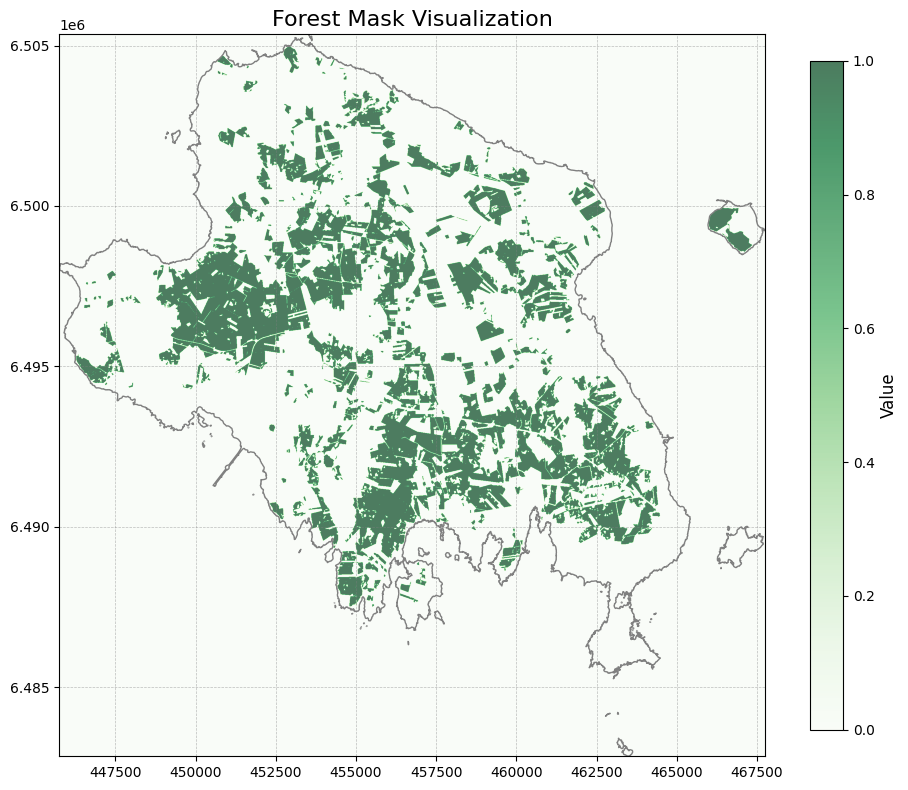

In [313]:
# Call visualization with the output raster
visualize_forest_mask('cleaned_metsaregister_binary.tif', kov_filtered_gdf, title="Forest Mask Visualization")

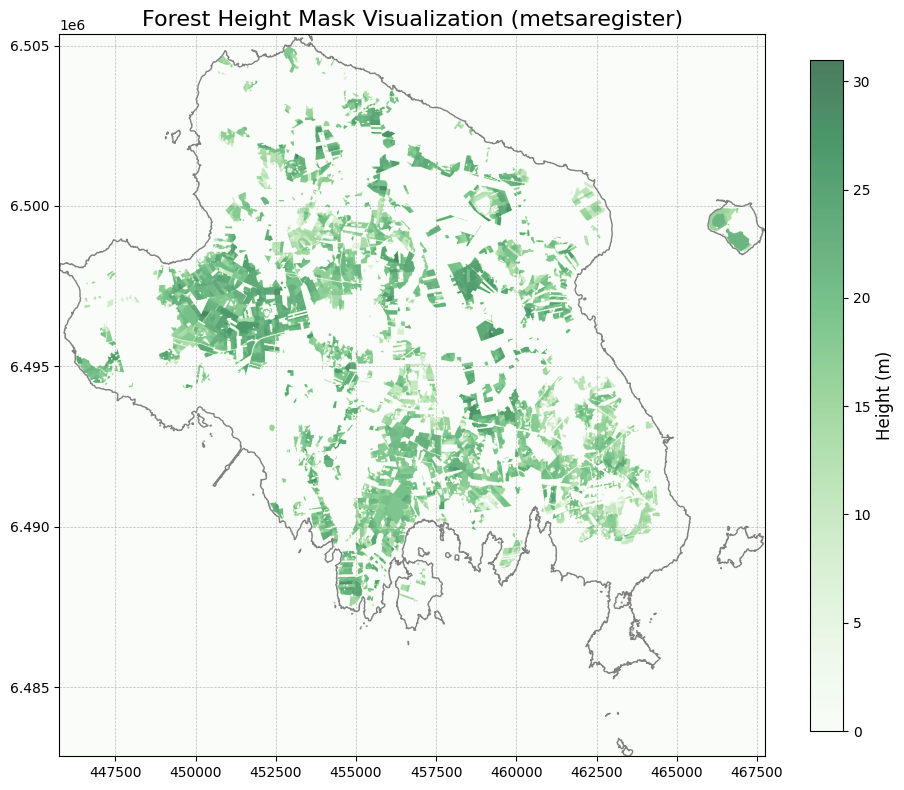

In [314]:
# Call visualization with the output raster
visualize_forest_mask('cleaned_metsaregister_korgus.tif', kov_filtered_gdf, title="Forest Height Mask Visualization (metsaregister)", clabel='Height (m)')

# Cleaned raster differences

In [284]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def plot_raster_difference_with_geometries(raster1_path, raster2_path, gdf, title="Difference between Rasters", cm='Reds'):
    """
    Calculates and plots the difference between two raster files, ignoring -99999.0 values,
    and overlays geometries from a GeoDataFrame.

    Args:
        raster1_path (str): Path to the first raster file.
        raster2_path (str): Path to the second raster file.
        gdf (GeoDataFrame): GeoDataFrame containing geometries to overlay.
        title (str): Title for the plot.
    """
    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        raster1 = src1.read(1)
        raster2 = src2.read(1)

        # Check if the rasters have the same shape
        if raster1.shape != raster2.shape:
            raise ValueError("Error: Rasters have different shapes. Cannot calculate the difference.")

        # Ensure both rasters have the same CRS and transform
        if src1.crs != src2.crs or src1.transform != src2.transform:
            raise ValueError("Error: Rasters have different CRS or transform. Alignment required.")

        # Create a mask to ignore -99999.0 values
        ignore_mask = (raster1 != -99999.0) & (raster2 != -99999.0)

        # Calculate the difference only where the mask is True
        difference = np.where(ignore_mask, raster1 - raster2, np.nan)

        # Plot the difference
        fig, ax = plt.subplots(figsize=(12, 8))

        # Show raster with transform and CRS, using the mask for no-data
        show(
            difference,
            transform=src1.transform,
            ax=ax,
            cmap=cm,
            alpha=0.8,
            vmin=np.nanmin(difference),  # Set minimum value for the colormap (excluding NaN)
            vmax=np.nanmax(difference)  # Set maximum value for the colormap (excluding NaN)
        )

        # Set plot title, grid, ticks, and overlay geometries (same as before)
        ax.set_title(title, fontsize=16)
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=10)
        gdf.plot(
            ax=ax,
            edgecolor='gray',
            linewidth=0.5,
            facecolor='none',
            alpha=0.8
        )

        # Add a colorbar
        cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label('Difference Value', fontsize=12)

        plt.tight_layout()
        plt.show()

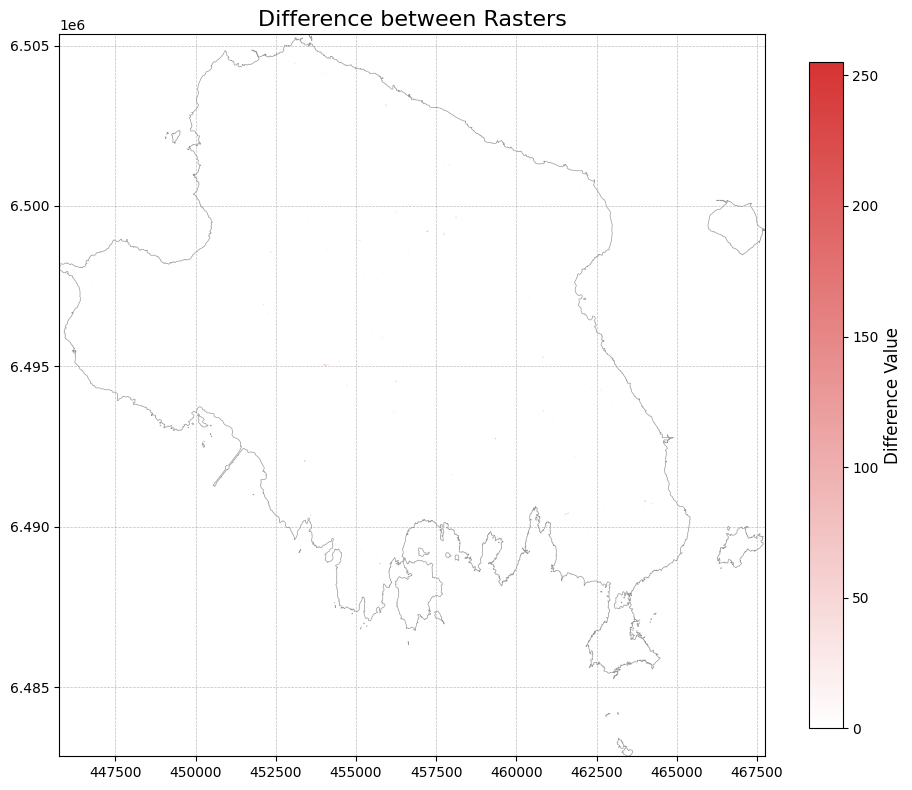

In [285]:
import matplotlib.colors as mcolors

# Create custom colormap from white to red
colors = [(1, 1, 1), (0.8, 0, 0)]  # White to red
cmap_name = 'white_to_red'
ccm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

plot_raster_difference_with_geometries('cleaned_metsaregister_binary.tif', 'metsaregister_binary.tif', kov_filtered_gdf,cm=ccm)

# Canopy Height Model

In [286]:
import requests
import os

def download_tif_files(urls, save_folder='.', min_size_gb=1):
    for url in urls:
        # Extract filename from URL
        filename = url.split('&')[-2].split('=')[-1]
        file_path = os.path.join(save_folder, filename)

        # Check if file exists and is larger than min_size_gb
        if os.path.exists(file_path) and os.path.getsize(file_path) > min_size_gb * 1024**3:
            print(f"Skipping {filename}: File already exists and is larger than {min_size_gb} GB.")
            continue  # Skip to the next URL

        # Send a GET request to the URL
        response = requests.get(url, stream=True)

        if response.status_code == 200:
            # Save the file locally
            with open(file_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            print(f"Downloaded: {filename}")
        else:
            print(f"Failed to download {filename}. HTTP Status Code: {response.status_code}")

# List of URLs to download, including the new first URL
urls = [
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2023_suvi.tif&page_id=614",
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2022_suvi.tif&page_id=614",
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2021_suvi.tif&page_id=614",
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2020_suvi.tif&page_id=614"
]

# Call the function to download the files
download_tif_files(urls)


Skipping CHM_2023_suvi.tif: File already exists and is larger than 1 GB.
Skipping CHM_2022_suvi.tif: File already exists and is larger than 1 GB.
Skipping CHM_2021_suvi.tif: File already exists and is larger than 1 GB.
Skipping CHM_2020_suvi.tif: File already exists and is larger than 1 GB.


In [305]:
import requests
import os

def download_tif_files(urls, save_folder='.', min_size_gb=1):
    file_paths = []  # Initialize an empty list to store file paths
    for url in urls:
        # Extract filename from URL
        filename = url.split('&')[-2].split('=')[-1]
        file_path = os.path.join(save_folder, filename)
        file_paths.append(filename)  # Add the unique file path to the list

        # Check if file exists and is larger than min_size_gb
        if os.path.exists(file_path) and os.path.getsize(file_path) > min_size_gb * 1024**3:
            print(f"Skipping {filename}: File already exists and is larger than {min_size_gb} GB.")
            continue  # Skip to the next URL

        # Send a GET request to the URL
        response = requests.get(url, stream=True)

        if response.status_code == 200:
            # Save the file locally
            with open(file_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            print(f"Downloaded: {filename}")
        else:
            print(f"Failed to download {filename}. HTTP Status Code: {response.status_code}")

    return file_paths  # Return the list of file paths

# List of URLs to download
urls = [
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2023_suvi.tif&page_id=614",
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2022_suvi.tif&page_id=614",
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2021_suvi.tif&page_id=614",
    "https://geoportaal.maaamet.ee/index.php?lang_id=1&plugin_act=otsing&andmetyyp=tk_korgusmudelid&dl=1&f=CHM_2020_suvi.tif&page_id=614"
]

# Call the function to download the files and get the file paths
downloaded_file_paths = download_tif_files(urls)

# Print the list of downloaded file paths
print(f"Downloaded file paths: {downloaded_file_paths}")

Skipping CHM_2023_suvi.tif: File already exists and is larger than 1 GB.
Skipping CHM_2022_suvi.tif: File already exists and is larger than 1 GB.
Skipping CHM_2021_suvi.tif: File already exists and is larger than 1 GB.
Skipping CHM_2020_suvi.tif: File already exists and is larger than 1 GB.
Downloaded file paths: ['CHM_2023_suvi.tif', 'CHM_2022_suvi.tif', 'CHM_2021_suvi.tif', 'CHM_2020_suvi.tif']


In [287]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd


def plot_tif_coverage(file_paths, gdf):
    """
    Plots the coverage areas of .tif files overlaid on a GeoDataFrame.

    Args:
        file_paths (list): List of paths to .tif files.
        gdf (geopandas.GeoDataFrame): GeoDataFrame to overlay.
    """
    coverage_polygons = []

    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            bounds = src.bounds
            bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
            coverage_polygons.append({"geometry": bbox, "file": file_path})

    gdf_p = gpd.GeoDataFrame(coverage_polygons, geometry="geometry")

    # Set the CRS for gdf_p using the CRS of the first tif file (assuming they all have the same CRS)
    with rasterio.open(file_paths[0]) as src:
        gdf_p.crs = src.crs


    # Ensure both GeoDataFrames have the same CRS
    gdf_p = gdf_p.to_crs(gdf.crs)  # Reproject if necessary

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot KOV first to ensure visibility
    gdf.plot(
        ax=ax,
        edgecolor="gray",
        linewidth=0.8,  # Increased linewidth for visibility
        facecolor="none",
        alpha=0.8,
        zorder=2,  # Higher zorder to bring on top
    )

    gdf_p.plot(ax=ax, alpha=0.3, edgecolor="black", legend=True, zorder=1)
    metsaregister_gdf_modified.plot(
        ax=ax, color="Green", edgecolor="none", zorder=0
    )

    for idx, row in gdf_p.iterrows():
        ax.annotate(
            row["file"].split("/")[-1],
            xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
            ha="center",
            fontsize=8,
        )

    plt.title("Coverage Areas of .tif Files")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

## Visualize CHM

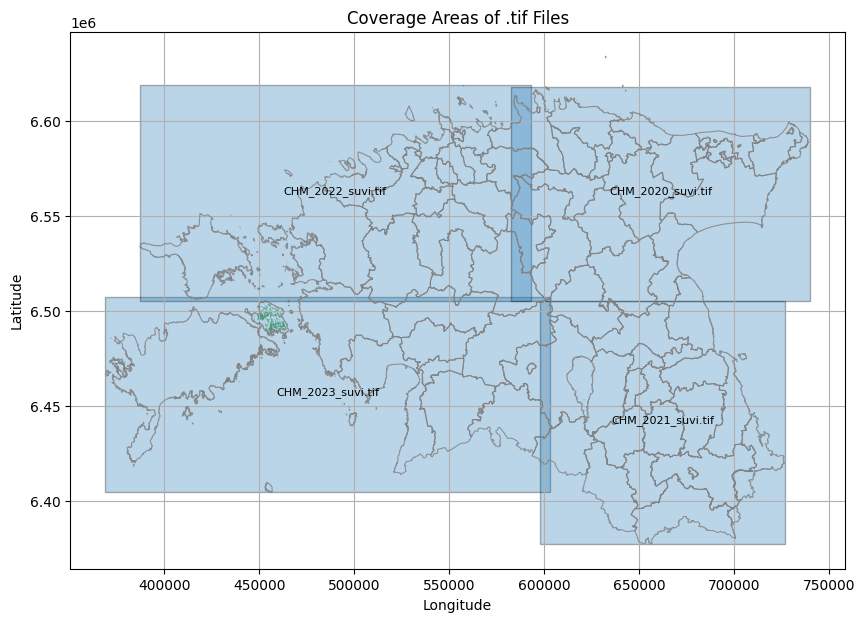

In [288]:
# Call the function to plot
plot_tif_coverage(file_paths, gdf_kov)

In [289]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box

def find_intersecting_tifs(tif_files, metsaregister_gdf_modified):
    """
    Finds tif files whose bounding boxes intersect with the geometries in metsaregister_gdf_modified.

    Args:
        tif_files (list): A list of paths to tif files.
        metsaregister_gdf_modified (geopandas.GeoDataFrame): A GeoDataFrame with a 'geometry' column.

    Returns:
        list: A list of tif file paths that intersect with any geometry in metsaregister_gdf_modified.
    """
    intersecting_tifs = []
    for tif_file in tif_files:
        try:
            with rasterio.open(tif_file) as src:
                tif_bounds = src.bounds
                tif_bbox = box(*tif_bounds)  # Create a bounding box from the tif bounds

                # Check for intersection with any polygon in the GeoDataFrame
                for _, row in metsaregister_gdf_modified.iterrows():
                    if tif_bbox.intersects(row['geometry']):
                        intersecting_tifs.append(tif_file)
                        break # Move to the next tif file once an intersection is found
        except Exception as e:
            print(f"Error processing {tif_file}: {e}")
            continue  # Skip to the next tif file if an error occurs
    return intersecting_tifs

# Example usage (assuming you have a list of tif files and the GeoDataFrame):

# Example list of tif files
tif_files = ["CHM_2023_suvi.tif", "CHM_2022_suvi.tif", "CHM_2021_suvi.tif", "CHM_2020_suvi.tif"]

# Call the function to get the intersecting tif files.
intersecting_tifs = find_intersecting_tifs(tif_files, metsaregister_gdf_modified)

print(f"Tif files intersecting with metsaregister_gdf_modified: {intersecting_tifs}")

Tif files intersecting with metsaregister_gdf_modified: ['CHM_2023_suvi.tif']


## Mask CHM

In [4]:
for target_tif in intersecting_tifs:
    # Construct the output file path
    output_file = os.path.join(output_folder, f"{kov}_aligned_masked_taimkattemudel_{os.path.basename(target_tif)}")

    # Mask raster
    mask_raster('cleaned_metsaregister_binary.tif', target_tif, output_file)

    print(output_file)

    # Visualize the forest mask
    visualize_forest_mask(output_file, kov_filtered_gdf, title="Forest Mask Visualization")

NameError: name 'intersecting_tifs' is not defined

# Diferences in forest height

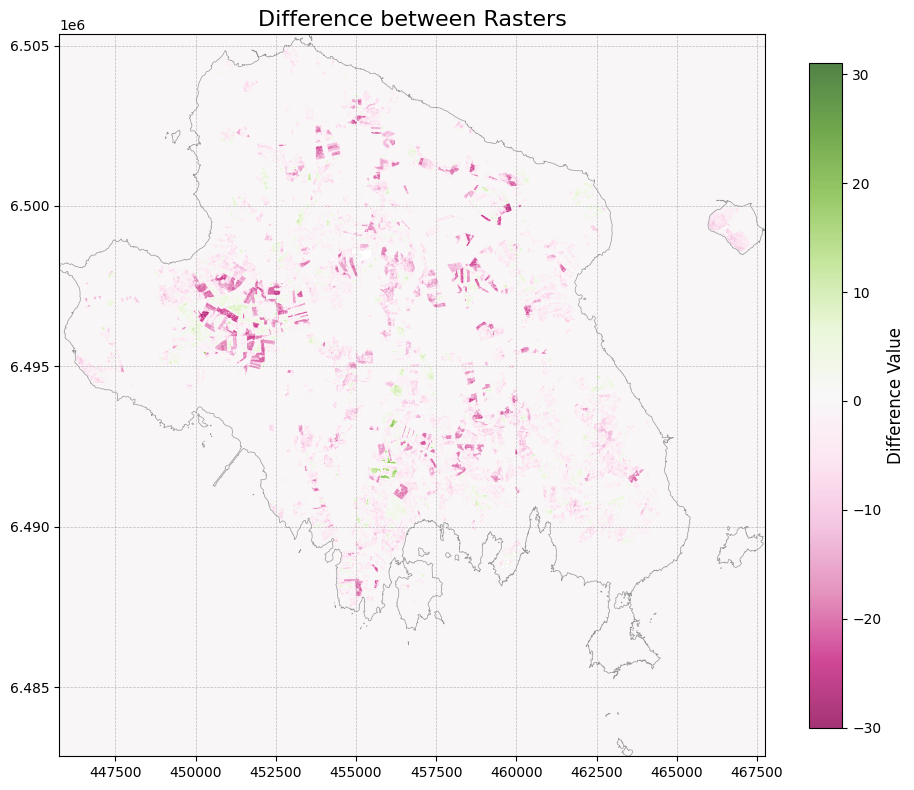

In [293]:
for target_tif in intersecting_tifs:
    # Construct the output file path
    output_file = os.path.join(output_folder, f"{kov}_aligned_masked_taimkattemudel_{os.path.basename(target_tif)}")

    # Visualize the foreest diferents

    plot_raster_difference_with_geometries(output_file, '/content/cleaned_metsaregister_korgus.tif', kov_filtered_gdf, cm='PiYG')

# Raster classification

In [294]:
import rasterio
import numpy as np

def reclassify_raster(input_path, output_path, nodata_value=-99999):
    """
    Reclassifies a raster into height classes, retaining NoData values.

    Args:
        input_path (str): Path to the input raster.
        output_path (str): Path to save the reclassified raster.
        nodata_value (int/float): Value representing NoData in the raster.
    """
    with rasterio.open(input_path) as src:
        chm_data = src.read(1)
        meta = src.meta.copy()

        # Use a larger data type to handle the NoData value
        reclassified = np.full_like(chm_data, fill_value=nodata_value, dtype=np.int32)

        # Apply classification while retaining NoData values
        reclassified[(chm_data >= 0) & (chm_data < 9)] = 1  # Class 1: < 9 m
        reclassified[(chm_data >= 9) & (chm_data <= 16)] = 2  # Class 2: 9 - 16 m
        reclassified[chm_data > 16] = 3  # Class 3: > 16 m
        reclassified[chm_data == nodata_value] = nodata_value  # Retain NoData

        # Update metadata to use int32 and set NoData value
        meta.update(dtype='int32', nodata=nodata_value)

        # Save the reclassified raster
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(reclassified, 1)

    print(f"Reclassified raster saved to {output_path}")


In [295]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

def visualize_reclassified_forest_mask(raster_path, title="Forest Mask Visualization", clabel='Value'):
    """
    Visualizes the reclassified forest mask raster with a professional overlay,
    excluding no-data values and adding a fourth class for 0 values.

    Parameters:
    raster_path (str): Path to the raster file.
    title (str): Title for the plot.
    clabel (str): Label for the colorbar.
    """
    with rasterio.open(raster_path) as src:
        forest_mask = src.read(1)  # Read the first band
        transform = src.transform
        crs = src.crs

    # Mask no-data values (0) using NaN for better visualization
    masked_forest_mask = np.where(forest_mask == 0, np.nan, forest_mask)
    masked_forest_mask = np.where(forest_mask == -99999, np.nan, masked_forest_mask)

    # Define class labels, colors, and values
    class_labels = {
        0: ("No Forest", "white"),
        1: ("Class 1: < 9 m", "lightgreen"),
        2: ("Class 2: 9 - 16 m", "green"),
        3: ("Class 3: > 16 m", "darkgreen"),
    }

    # Create a custom colormap, ensuring values and colors align
    all_colors = [color for value, (label, color) in class_labels.items()]
    cmap = plt.cm.colors.ListedColormap(all_colors)

    # Get unique values in the raster, excluding NaN
    unique_values = np.unique(masked_forest_mask[~np.isnan(masked_forest_mask)])

    # Plot the forest mask
    fig, ax = plt.subplots(figsize=(12, 8))

    # Show raster using the custom colormap and masking
    im = show(masked_forest_mask, transform=transform, ax=ax, cmap=cmap, alpha=0.7, vmin=min(unique_values), vmax=max(unique_values))

    # Add title, grid, and ticks for professional look
    ax.set_title(title, fontsize=16)
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a legend for each class
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                   markersize=10, markerfacecolor=color)
                       for _, (label, color) in class_labels.items()]
    ax.legend(handles=legend_elements, loc='upper right', title="Classes")

    # Set CRS labels for clarity
    ax.set_xlabel("Longitude (EPSG:3301)")
    ax.set_ylabel("Latitude (EPSG:3301)")

    # Display the plot
    plt.tight_layout()
    plt.show()

# Visualize reclassification

Reclassified raster saved to /content/Muhu_reclassified_taimkattemudel_CHM_2023_suvi.tif


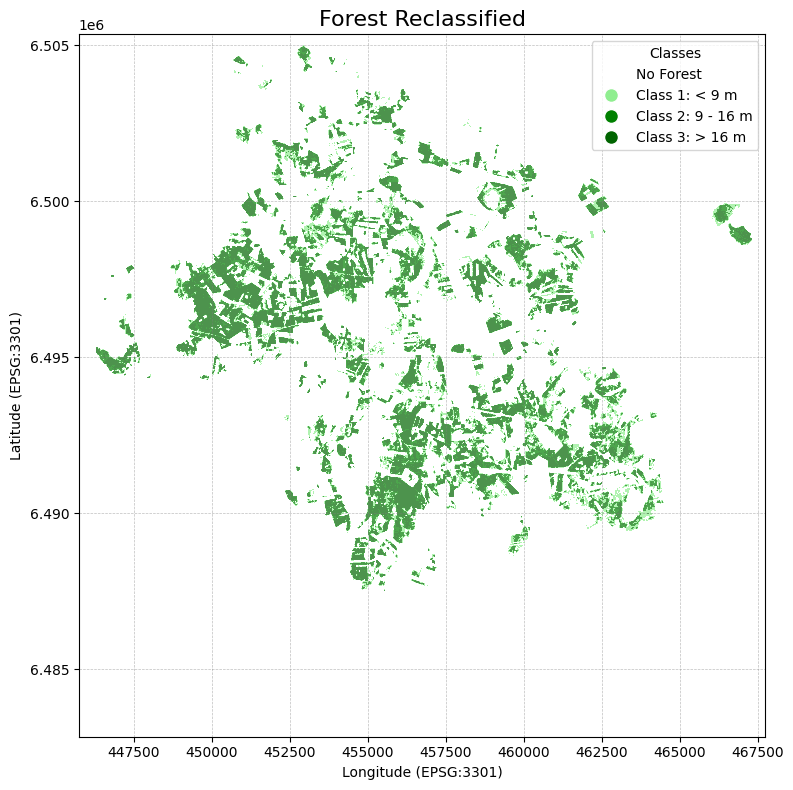

In [296]:
for target_tif in intersecting_tifs:
    # Construct the input and output file path
    input_raster = os.path.join(output_folder, f"{kov}_aligned_masked_taimkattemudel_{os.path.basename(target_tif)}")
    output_raster = os.path.join(output_folder, f"{kov}_reclassified_taimkattemudel_{os.path.basename(target_tif)}")
    reclassify_raster(input_raster, output_raster)
    visualize_reclassified_forest_mask(output_raster, title="Forest Reclassified")